<a href="https://colab.research.google.com/github/Sravan000/ocr/blob/main/OCRVO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# from keras.layers import Dense, Conv2D, BatchNormalization, Activation
# from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
np.set_printoptions(suppress=True)
sns.set()

In [9]:
def load_az_dataset(datasetPath):
	# initialize the list of data and labels
	data = []
	labels = []
	alpha_count = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0
	               ,24:0,25:0}
	# loop over the rows of the A-Z handwritten digit dataset
	for row in open(datasetPath):
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		if alpha_count[label] <= 2600:
			alpha_count[label] += 1
			image = np.array([int(x) for x in row[1:]], dtype="uint8")
			# images are represented as single channel (grayscale) images
			# that are 28x28=784 pixels -- we need to take this flattened
			# 784-d list of numbers and repshape them into a 28x28 matrix
			image = image.reshape((28, 28))
			# update the list of data and labels
			data.append(image)
			labels.append(label)
			# convert the data and labels to NumPy arrays
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	# return a 2-tuple of the A-Z data and labels
	return (data, labels)

In [10]:
def load_mnist_dataset():
	# load the MNIST dataset and stack the training data and testing
	# data together (we'll create our own training and testing splits
	# later in the project)
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

In [11]:
(digitsData, digitsLabels) = load_mnist_dataset()

(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/A_Z Handwritten Data.csv')

11501568/11490434 [==============================] - 0s 0us/step


In [12]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a 3 channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = X_rgb = np.stack([data, data, data], axis=-1)
data /= 255.0

In [13]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, random_state=42)

In [1]:
# from google.colab import files
# files.download("/content/saved_models")

In [15]:

base_model = ResNet50(input_shape=(32,32,3), include_top=False, weights="imagenet")
for layer in base_model.layers:
  layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(36, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=5, verbose = 2)

In [16]:
# Main function
data_augmentation = False
batch_size = 32
epochs = 10

model.compile(loss ='categorical_crossentropy',
			optimizer = 'adam',
			metrics =['accuracy'])
model.summary()


lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
							cooldown = 0,
							patience = 5,
							min_lr = 0.5e-6)


callbacks = [lr_reducer]

# Run training, with or without data augmentation.
if not data_augmentation:
	print('Not using data augmentation.')
	model.fit(trainX, trainY,
			batch_size = batch_size,
			epochs = epochs,
			validation_data =(testX, testY),
			shuffle = True,
			callbacks = callbacks)
else:
	print('Using real-time data augmentation.')
	# This will do preprocessing and realtime data augmentation:
	datagen = ImageDataGenerator(
		# set input mean to 0 over the dataset
		featurewise_center = False,
		# set each sample mean to 0
		samplewise_center = False,
		# divide inputs by std of dataset
		featurewise_std_normalization = False,
		# divide each input by its std
		samplewise_std_normalization = False,
		# apply ZCA whitening
		zca_whitening = False,
		# epsilon for ZCA whitening
		zca_epsilon = 1e-06,
		# randomly rotate images in the range (deg 0 to 180)
		rotation_range = 0,
		# randomly shift images horizontally
		width_shift_range = 0.1,
		# randomly shift images vertically
		height_shift_range = 0.1,
		# set range for random shear
		shear_range = 0.,
		# set range for random zoom
		zoom_range = 0.,
		# set range for random channel shifts
		channel_shift_range = 0.,
		# set mode for filling points outside the input boundaries
		fill_mode ='nearest',
		# value used for fill_mode = "constant"
		cval = 0.,
		# randomly flip images
		horizontal_flip = True,
		# randomly flip images
		vertical_flip = False,
		# set rescaling factor (applied before any other transformation)
		rescale = None,
		# set function that will be applied on each input
		preprocessing_function = None,
		# image data format, either "channels_first" or "channels_last"
		data_format = None,
		# fraction of images reserved for validation (strictly between 0 and 1)
		validation_split = 0.0)

	# Compute quantities required for featurewise normalization
	# (std, mean, and principal components if ZCA whitening is applied).
	datagen.fit(trainX)

	# Fit the model on the batches generated by datagen.flow().
	model.fit_generator(datagen.flow(trainX, trainY, batch_size = batch_size),
						validation_data =(testX, testY),
						epochs = epochs, verbose = 1, workers = 4,
						callbacks = callbacks)

# Score trained model.
scores = model.evaluate(testX, testY, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                73764     
Total params: 23,661,476
Trainable params: 73,764
Non-trainable params: 23,587,712
_________________________________________________________________
Not using data augmentation.
Epoch 1/10
3368/3368 [==============================] - 558s 165ms/step - loss: 1.3767 - accuracy: 0.6322 - val_loss: 0.9691 - val_accuracy: 0.7328
Epoch 2/10
3368/3368 [==============================] - 555s 165ms/step - loss: 0.8395 - accuracy: 0.7649 - val_loss: 0.7672 - val_accuracy: 0.7827
Epoch 3/10
3368/3368 [====================

In [29]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [ ]:

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

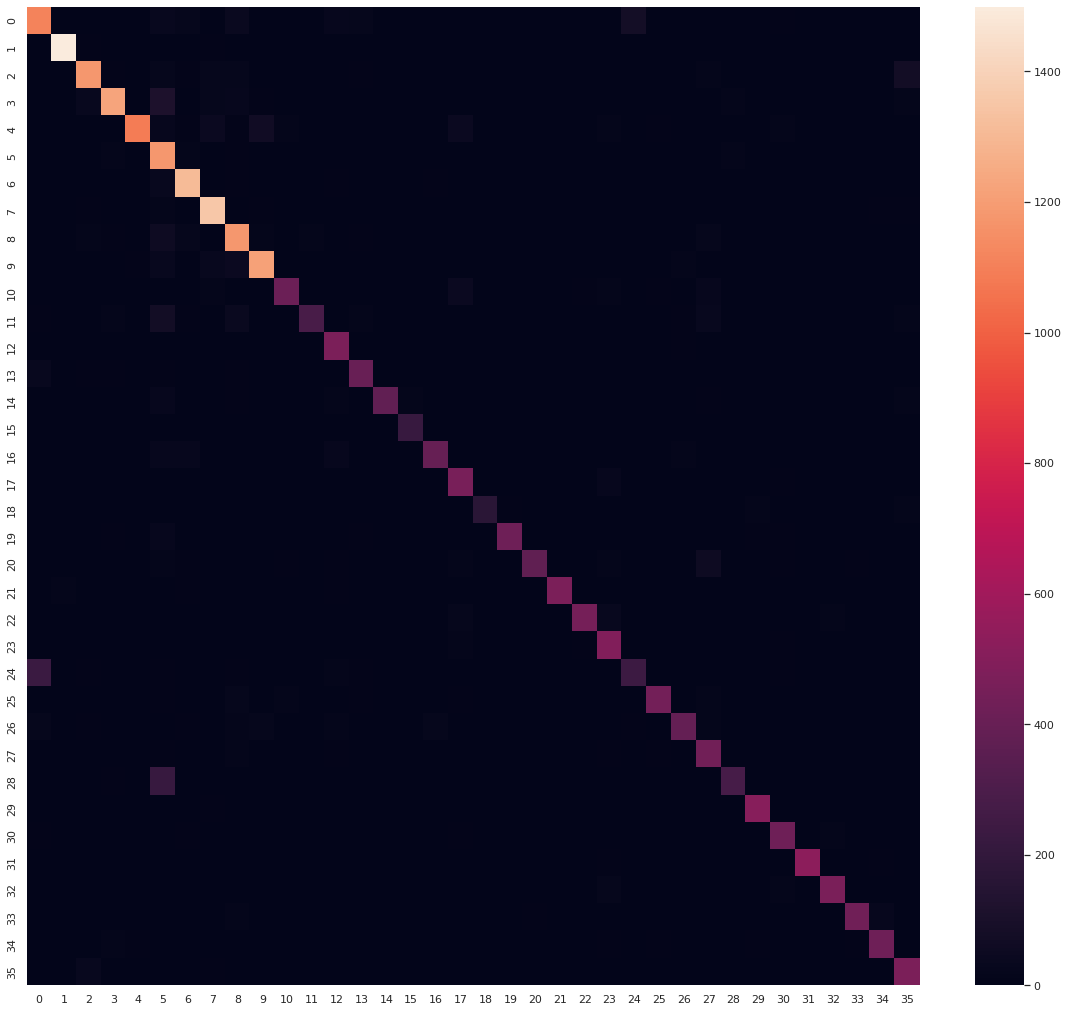

In [19]:
plt.figure(figsize=(20,18))
sns.heatmap(confusion_matrix(testY.argmax(axis=1),predictions.argmax(axis=1)));

In [20]:
model.save('/content/drive/MyDrive/DeepLearningModels')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearningModels/assets


In [23]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/DeepLearningModels')

In [21]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2



In [61]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('/content/han_test.png')

def find_text_regions_and_predict(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # perform edge detection, find contours in the edge map, and sort the
  # resulting contours from left-to-right
  edged = cv2.Canny(blurred, 30, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]
  # loop over the contours
  for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
      roi = gray[y:y + h, x:x + w]
      thresh = cv2.threshold(roi, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      (tH, tW) = thresh.shape
      # if the width is greater than the height, resize along the
      # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=32)
      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=32)
          # re-grab the image dimensions (now that its been resized)
      # and then determine how much we need to pad the width and
      # height such that our image will be 32x32
      (tH, tW) = thresh.shape
      dX = int(max(0, 32 - tW) / 2.0)
      dY = int(max(0, 32 - tH) / 2.0)
      # pad the image and force 32x32 dimensions
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(0, 0, 0))
      padded = cv2.resize(padded, (32, 32))
      # print(padded.shape)
      # prepare the padded image for classification via our
      # handwriting OCR model
      padded = padded.astype("float32") / 255.0
      # padded = np.expand_dims(padded, axis=-1)
      padded = np.array(padded, dtype="float32")
      padded = np.stack([padded, padded, padded], axis=-1)
      x = np.expand_dims(padded, axis=0)
      probs = model.predict(x)
      i = np.argmax(probs)
      if np.max(probs) >0.50:
        print("Predicted : ",labelNames[i])



In [62]:
find_text_regions_and_predict(image)

Predicted :  H
Predicted :  W
Predicted :  L
Predicted :  D
Predicted :  L
Predicted :  D
Predicted :  0
Predicted :  L
Predicted :  D
Predicted :  H
Predicted :  F
Predicted :  L
Predicted :  L
Predicted :  U
Predicted :  L
Predicted :  D


In [95]:
from google.colab.patches import cv2_imshow

In [ ]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
        # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# print(padded.shape)
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		# padded = np.expand_dims(padded, axis=-1)
		padded = np.array(padded, dtype="float32")
		padded = np.stack([padded, padded, padded], axis=-1)
		x = np.expand_dims(padded, axis=0)
		probs = model.predict(x)
		i = np.argmax(probs)
		if np.max(probs) >0.50:
			print("Predicted : ",labelNames[i])
		# update our list of characters that will be OCR'd

Predicted :  H
Predicted :  W
Predicted :  L
Predicted :  D
Predicted :  L
Predicted :  D
Predicted :  0
Predicted :  L
Predicted :  D
Predicted :  H
Predicted :  F
Predicted :  L
Predicted :  L
Predicted :  U
Predicted :  L
Predicted :  D


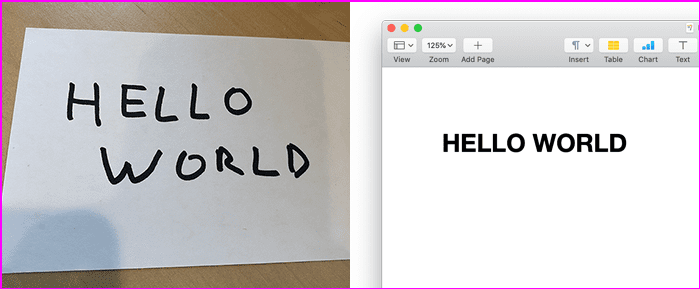

In [49]:

import cv2


def captch_ex(file_name):
    img = cv2.imread(file_name)

    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # for black text , cv.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion 
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # dilate , more the iteration more the dilation

    # for cv2.x.x

    # unknown, contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # findContours returns 3 variables for getting contours

    # for cv3.x.x comment above line and uncomment line below

    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)


    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]
        find_text_regions_and_predict(cropped)
        # s = file_name + '/crop_' + str(index) + '.jpg' 
        # cv2.imwrite(s , cropped)
        # index = index + 1

        
    # write original image with added contours to disk
    cv2_imshow(img)
    cv2.waitKey()


file_name = '/content/han_test.png'
captch_ex(file_name)

In [34]:
from google.colab.patches import cv2_imshow

In [38]:
image = cv2.imread('/content/ocr_test7.jpeg')
find_text_regions_and_predict(image)

Predicted :  1
Predicted :  1
Predicted :  1
Predicted :  1
Predicted :  1
Predicted :  1
Predicted :  1
Predicted :  6
Predicted :  1
Predicted :  4
Predicted :  2
Predicted :  1
Predicted :  H
Predicted :  H
Predicted :  1
Predicted :  4
Predicted :  4


In [39]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2

In [40]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('/content/ocr_test7.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

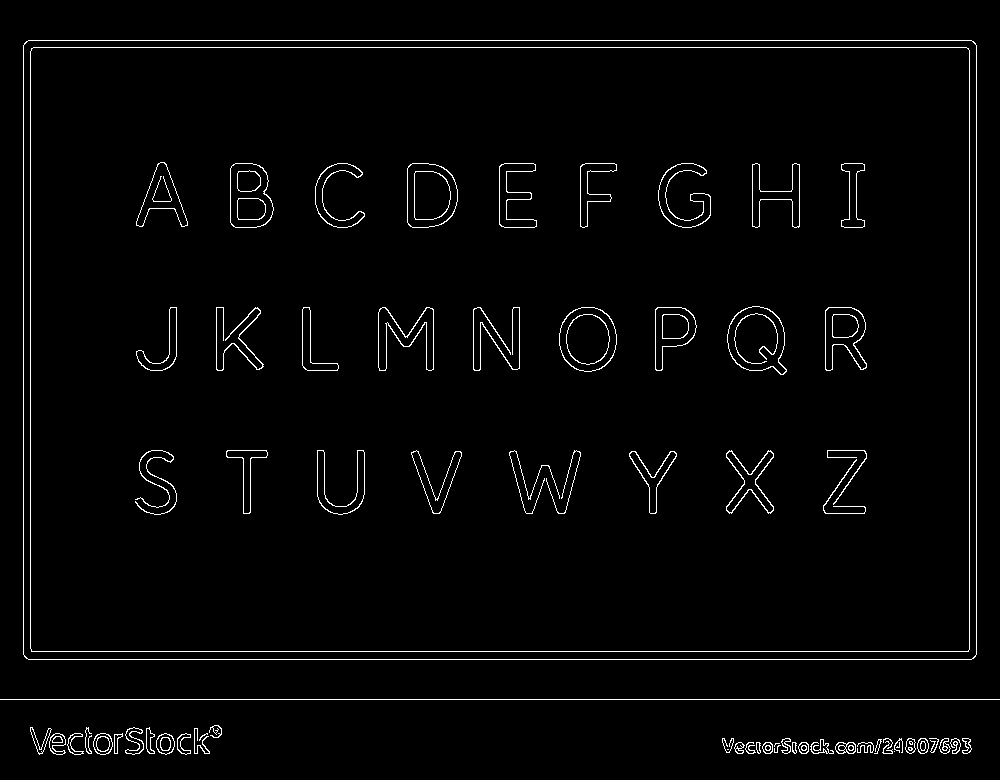

In [44]:
cv2_imshow(edged)

In [45]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
   # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))
  

In [46]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
# preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [ ]:
# loop over the predictions and bounding box locations together
for x, y, w, h in boxes:
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	# i = np.argmax(pred)
	# prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	# print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	# cv2.putText(image, label, (x - 10, y - 10),
		# cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	# show the image
	cv2_imshow(image)
	cv2.waitKey(0)

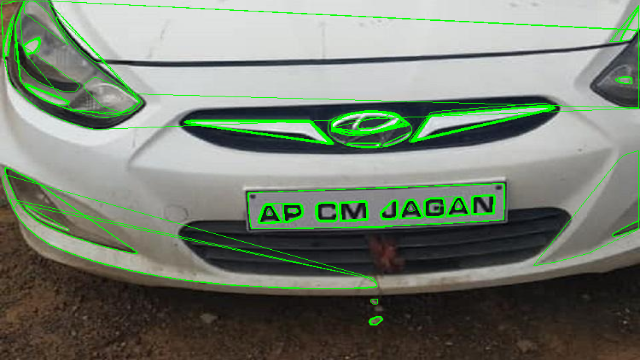

In [58]:
mser = cv2.MSER_create()
img = cv2.imread('/content/ocr_test2.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
regions, _ = mser.detectRegions(gray)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(img, hulls, 1, (0, 255, 0))
cv2_imshow(cv2.resize(img,(640,360)))